https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw
➡ CO (42101)

This is the link to the original dataset the model needs to be trained on

**The data file I used in this notebook is a reduced version of the original to run faster on colab

**Original(1000000+ lines) ThisVersion(200 lines)

In [ ]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 78.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
import math
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [ ]:
#Read csv

df = pd.read_csv("hourly_42101_2021_new.csv")

In [ ]:
#check df

df

In [ ]:
#dropping all irrelevant columns (only kept the necessary ones)

df = df.drop(["State Code", "County Code", "Parameter Code", "POC", "Datum",
              "Site Num", "MDL", "Uncertainty", "Qualifier", "Method Type",
              "Method Code", "Method Name", "Date of Last Change",
              "Parameter Name", "Units of Measure", "State Name", "County Name",
              "Date GMT", "Time GMT"], axis = 'columns')

In [ ]:
#checking drop

df

,Latitude,Longitude,Date Local,Time Local,Sample Measurement
0,33.553056,-86.815,1/1/2021,0:00,0.2
1,33.553056,-86.815,1/1/2021,1:00,0.1
2,33.553056,-86.815,1/1/2021,2:00,0.1
3,33.553056,-86.815,1/1/2021,3:00,0.1
4,33.553056,-86.815,1/1/2021,4:00,0.1
...,...,...,...,...,...
194,33.553056,-86.815,1/9/2021,11:00,0.2
195,33.553056,-86.815,1/9/2021,12:00,0.2
196,33.553056,-86.815,1/9/2021,13:00,0.2
197,33.553056,-86.815,1/9/2021,14:00,0.2


In [ ]:
df["Longitude"].shape[0]
df["Latitude"].shape[0]

199

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


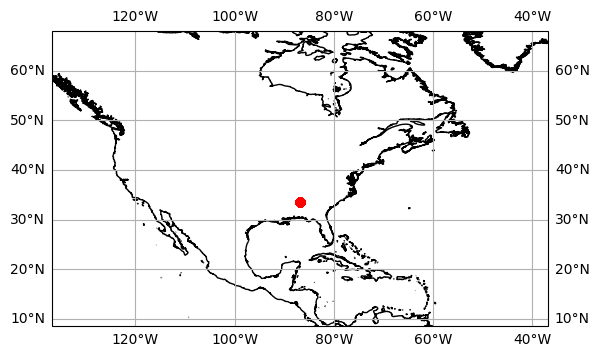

In [ ]:
# Use `%matplotlib inline` to display the map directly in Colab
%matplotlib inline

# Create a figure and axis with PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Customizing map with coastlines and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=1)  # Add coastlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

#Zooming out of map for better view of US
ax.set_extent([df["Longitude"][0] - 50, df["Longitude"][0] + 50, df["Latitude"][0] - 25, df["Latitude"][0] + 25])

#plotting all coordinates from dataset onto same map
for value in range(df["Longitude"].shape[0]):
  plot_lon = df["Longitude"][value]
  plot_lat = df["Latitude"][value]
  ax.plot(plot_lon, plot_lat, 'ro', markersize=6, transform=ccrs.PlateCarree())

plt.show()
#all coordinates concentrated to same point, b/c only small portion of data is being used

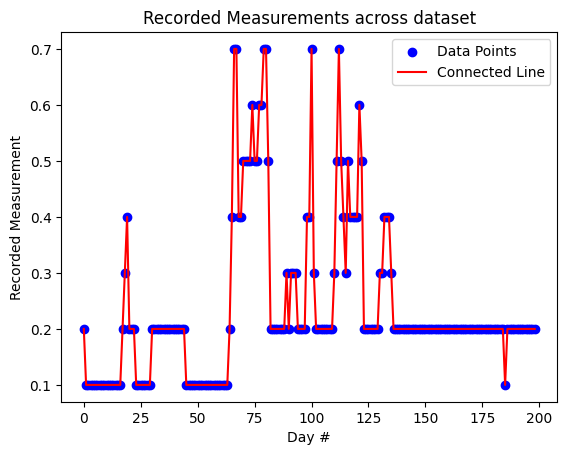

In [ ]:
#Creating scatter plot of sample measurements across portion of dataset utilized
#**Check with team for better approach to visualize this**

plt.scatter(range(df["Sample Measurement"].shape[0]), (df["Sample Measurement"]), marker='o', color='blue', label='Data Points')
plt.plot(range(df["Sample Measurement"].shape[0]), (df["Sample Measurement"]), linestyle='-', color='red', label='Connected Line')

# Add labels and a legend
plt.xlabel('Day #')
plt.ylabel('Recorded Measurement')
plt.title('Recorded Measurements across dataset')
plt.legend()

plt.show()

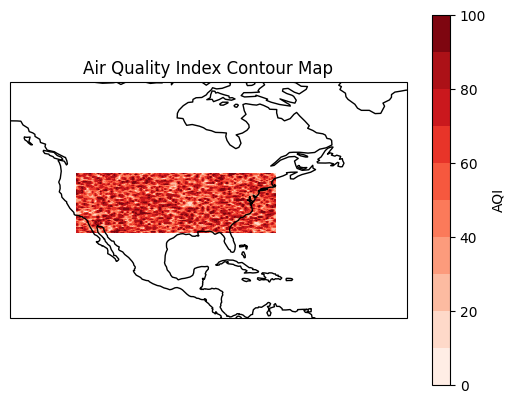

In [ ]:
# Example data (replace this with your AQI data and coordinates)
lats = np.linspace(30, 45, 50)
lons = np.linspace(-120, -70, 75)
aqi_data = np.random.rand(len(lats), len(lons)) * 100  # Example AQI values (0-100)

# Create a figure and axis with a PlateCarree projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([df["Longitude"][0] - 50, df["Longitude"][0] + 50, df["Latitude"][0] - 25, df["Latitude"][0] + 25])

# Create contour levels (adjust as needed)
levels = np.linspace(0, 100, 11)  # Contour levels from 0 to 100

# Create a contour plot with a colormap (e.g., 'Reds' for red)
contour = ax.contourf(lons, lats, aqi_data, levels=levels, cmap='Reds', transform=ccrs.PlateCarree())

# Add coastlines for reference
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', label='AQI')

# Set titles and labels
ax.set_title('Air Quality Index Contour Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
#First function converts date into day of year, and then normalizes it to scale of 0 to 1
#Second function converts time of day, into hour of day, and then normalizes it to scale of 0 to 1

def adjust_date(arr):
  adjusted_date_local = []

  for date in arr:
    temp = date.split("/")
    curr = temp[2] + "-" + temp[0] + "-"  + temp[1]
    period = pd.Period(curr)
    adjusted_date_local.append(int(period.day_of_year)/365)

  return adjusted_date_local

def adjust_time(arr):
  adjusted_time_local = []

  for time in arr:
    strTime = time.replace(":", ".")
    adjusted_time_local.append(float(strTime)/24)

  return adjusted_time_local

In [ ]:
#Creating the new adjusted columns by applying the functions to existing values
#Deleting old non-formatted columns

df["Date Local (adjusted)"] = adjust_date(df["Date Local"])
df["Time Local (adjusted)"] = adjust_time(df["Time Local"])

df = df.drop(["Date Local", "Time Local"], axis = 'columns')

In [ ]:
#function that normalizes the longitude and latitude to a scale of 0 to 1

def adjust_long_lat(arr):
  adjusted_long_lat = []

  for pos in arr:
    adjusted_long_lat.append(float(pos)/180)

  return adjusted_long_lat

In [ ]:
#Once again adding the new adjusted columns and deleting old non-formatted columns

df["Latitude (adjusted)"] = adjust_long_lat(df["Latitude"])
df["Longitude (adjusted)"] = adjust_long_lat(df["Longitude"])

df = df.drop(["Latitude", "Longitude"], axis = 'columns')

In [ ]:
def new_sin(arr):
  sin_ans = []

  for input in arr:
    sin_ans.append(math.sin(input))

  return sin_ans

def new_cos(arr):
  cos_ans = []

  for input in arr:
    cos_ans.append(math.cos(input))

  return cos_ans

In [ ]:
df["sin(day of year)"] = new_sin(df["Date Local (adjusted)"])
df["cos(day of year)"] = new_cos(df["Date Local (adjusted)"])
df["sin(time of day)"] = new_sin(df["Time Local (adjusted)"])
df["cos(time of day)"] = new_cos(df["Time Local (adjusted)"])

In [ ]:
#checking new edits to df

df

,Sample Measurement,Date Local (adjusted),Time Local (adjusted),Latitude (adjusted),Longitude (adjusted),sin(day of year),cos(day of year),sin(time of day),cos(time of day)
0,0.2,0.002740,0.000000,0.186406,-0.482306,0.002740,0.999996,0.000000,1.000000
1,0.1,0.002740,0.041667,0.186406,-0.482306,0.002740,0.999996,0.041655,0.999132
2,0.1,0.002740,0.083333,0.186406,-0.482306,0.002740,0.999996,0.083237,0.996530
3,0.1,0.002740,0.125000,0.186406,-0.482306,0.002740,0.999996,0.124675,0.992198
4,0.1,0.002740,0.166667,0.186406,-0.482306,0.002740,0.999996,0.165896,0.986143
...,...,...,...,...,...,...,...,...,...
194,0.2,0.024658,0.458333,0.186406,-0.482306,0.024655,0.999696,0.442454,0.896791
195,0.2,0.024658,0.500000,0.186406,-0.482306,0.024655,0.999696,0.479426,0.877583
196,0.2,0.024658,0.541667,0.186406,-0.482306,0.024655,0.999696,0.515565,0.856851
197,0.2,0.024658,0.583333,0.186406,-0.482306,0.024655,0.999696,0.550809,0.834631


In [ ]:
#Turning "Sample Measurement" column into target (output) array and dropping from df

target = df["Sample Measurement"]
df = df.drop("Sample Measurement", axis = 'columns')

In [ ]:
#Splitting dataset into 80/20 train/test split and checking shape

split_point1 = int(0.6 * len(df))
split_point2 = int(0.8 * len(df))

x_train = df[0:split_point1]
x_test = df[split_point1:split_point2]
x_val = df[split_point2:]

y_train = target[0:split_point1]
y_test = target[split_point1:split_point2]
y_val = target[split_point2:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(119, 8) (119,) (40, 8) (40,) (40, 8) (40,)


In [ ]:
#converting df DataFrame objects to Numpy, so reshape function can be applied

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
x_val = x_val.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_val = y_val.to_numpy()

Following code implements the method that utilizes 24 hours of input, to predict the next 24 hours

(other file utilizes 23 hours of input, to predict the 24th hour)

In [ ]:
#Defining function that uses sliding window method to divide input data set into sequences of 24 hours

def hourly_sequencer(inputArray):
  sequence_length = 24
  sequences = []

  for j in range(inputArray.shape[0]-sequence_length):
    window = []
    for i in range(sequence_length):
      window.append(inputArray[j+i])
      temp_window = np.array(window)

    sequences.append(temp_window.flatten())

  return sequences

In [ ]:
#Performs the 24 hour division on the training input data set, and training output data set

x_train_adjusted = hourly_sequencer(x_train)
x_train_adjusted = np.array(x_train_adjusted)

print(x_train_adjusted.shape)

y_train_final = hourly_sequencer(y_train)
y_train_final = np.array(y_train_final)

print(y_train_final.shape)

(95, 192)
(95, 24)


In [ ]:
#Reshaping current data format to fit 3D input array for LSTM
#(num_of_samples, num_timesteps, num_features)
#(total # of data points, 1 incremental timestep, 192 input categories)

x_train_final = np.reshape(x_train_adjusted, (x_train_adjusted.shape[0], 1, x_train_adjusted.shape[1]))

print(x_train_final.shape)

(95, 1, 192)


In [ ]:
#Building LSTM model

model = Sequential() #For linear stack of layers
model.add(LSTM(x_train_adjusted.shape[0], input_shape=(1, x_train_adjusted.shape[1]))) #LSTM dimensions (≈, 1, 192)
model.add(Dense(24)) #Fully connected output layer with 24 nodes (for predicting 24 hours)

In [ ]:
#Compiling and fitting dataset to model

#RMSE used beacuse it computes root mean squared error metric between y_true and y_pred
model.compile(loss="mean_squared_error", optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.fit(x_train_final, y_train_final, epochs=5, batch_size=32)

Epoch 1/5
3/3 [==============================] - 7s 11ms/step - loss: 0.0875 - root_mean_squared_error: 0.2958
Epoch 2/5
3/3 [==============================] - 0s 6ms/step - loss: 0.0454 - root_mean_squared_error: 0.2132
Epoch 3/5
3/3 [==============================] - 0s 6ms/step - loss: 0.0348 - root_mean_squared_error: 0.1864
Epoch 4/5
3/3 [==============================] - 0s 6ms/step - loss: 0.0336 - root_mean_squared_error: 0.1834
Epoch 5/5
3/3 [==============================] - 0s 6ms/step - loss: 0.0340 - root_mean_squared_error: 0.1845


In [ ]:
test = np.reshape(x_train_final[1], (x_train_final[1].shape[0], 1, x_train_final[1].shape[1]))
print(test.shape)

(1, 1, 192)


In [ ]:
test_predicted_val = model.predict(test)

1/1 [==============================] - 1s 638ms/step


In [ ]:
test_predicted_val

array([[0.17039582, 0.31042355, 0.18617867, 0.2916392 , 0.18283343,
        0.3105314 , 0.28381935, 0.25328597, 0.28530365, 0.24055193,
        0.3488671 , 0.30518746, 0.31295604, 0.24396965, 0.31773746,
        0.28238603, 0.3368412 , 0.34009048, 0.325251  , 0.23662394,
        0.1586398 , 0.19318287, 0.18697111, 0.29167038]], dtype=float32)

In [ ]:
y_train_final[1]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.2, 0.3, 0.4, 0.2, 0.2, 0.2, 0.1, 0.1])